cpu


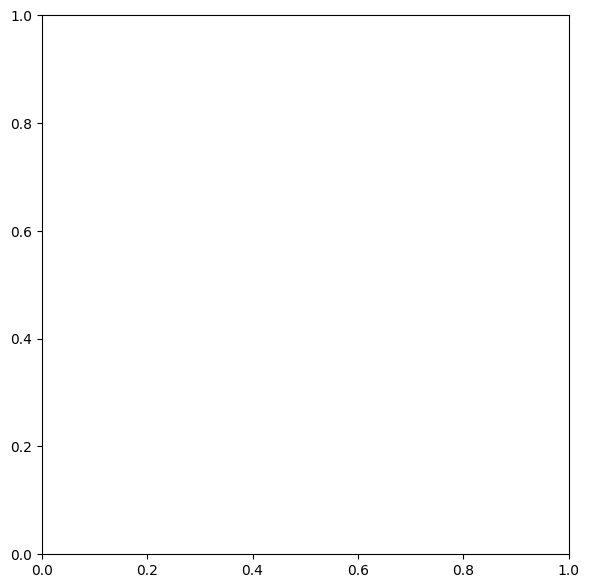

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, Subset
import utils
from data_utils import CustomDataset
from MLP_utils import load_model, save_model, fix_seed, SimpleMLP, LNLoss
import os
import pandas as pd
import pickle

fix_seed(utils.SEED)

device = torch.device("cpu")
print(device)

brands_in_csv_filename = [
    "ad",
    "brabantsdagblad",
    "destentor",
    "nu",
    "parool",
    "trouw",
    "volkskrant",
]


plt.rcParams['figure.facecolor'] = ('white') 
plt.gca().set_facecolor('white')


plt.rcParams["figure.figsize"] = (6.8,7)
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
model, config = load_model('last_run', device=device)

In [3]:
config

{'criterion': MSELoss(),
 'optimizer': 'adam',
 'weight_decay': 0.00039931079168018907,
 'depth': 3,
 'width': 256,
 'lr': 7.069564548473013e-05,
 'batch_size': 1024,
 'max_epochs': 50,
 'patience': 3,
 'batchnorm': False,
 'dropout': 0.09829492149373525,
 'input_size': 4634,
 'filenames_features': ['brand_ohe.pt',
  'publication_timestamp_emb.pt',
  'publication_weekday_ohe.pt',
  'num_words.pt',
  'num_paragraph.pt',
  'main_section_emb.pt',
  'subsections_emb.pt',
  'user_needs.pt',
  'lda_topics.pt',
  'iptc_topics_level_0.pt',
  'iptc_topics_level_1.pt',
  'title_emb.pt',
  'author_ohe.pt',
  'labels_emb.pt',
  'time_indications_mentioned_emb.pt']}

In [4]:
brands = utils.ALL_BRANDS


customdataset_kwargs = dict(
                        brands=brands, 
                        filenames_features=config["filenames_features"], 
                        dirpath_extracted_features=utils.DIRPATH_EXTRACTED_FEATURES,
                        device=device,
                        log_target=True, 
                        center_target=True,
                        filter_uniform_features=False, 
                        max_datapoints=None)
try:
    dataset = CustomDataset(**customdataset_kwargs)
except torch.cuda.OutOfMemoryError as e:
    print("There was a torch.cuda.OutOfMemoryError. Proceeding with loading the data on the cpu.")
    customdataset_kwargs['device'] = torch.device(device)
    dataset = CustomDataset(**customdataset_kwargs)
    
dataset.features.shape[1], dataset.device

(4634, device(type='cpu'))

In [5]:
with open(os.path.join(utils.DIRPATH_INDICES, 'train_dataset_indices.pkl'), 'rb') as f:
    train_dataset_indices = pickle.load(f)

with open(os.path.join(utils.DIRPATH_INDICES, 'val_dataset_indices.pkl'), 'rb') as f:
    val_dataset_indices = pickle.load(f)

with open(os.path.join(utils.DIRPATH_INDICES, 'test_dataset_indices.pkl'), 'rb') as f:
    test_dataset_indices = pickle.load(f)

In [6]:
with torch.no_grad():
    model.eval()
    # metric = nn.MSELoss(reduction='none')
    metric = nn.L1Loss(reduction='none')

    y_test = dataset[test_dataset_indices][1]
    y_pred_test = model(dataset[test_dataset_indices][0])
    
    metric_score_test = metric(y_pred_test, y_test)
    metric_score_test = metric_score_test.squeeze()
    y_pred_test = y_pred_test.squeeze()

In [7]:
test_sort = torch.sort(metric_score_test, dim=0, descending=True)
test_sort_indices = torch.tensor(test_dataset_indices)[test_sort.indices]
test_sort_values = test_sort.values

test_pred = y_pred_test[test_sort.indices]
test_pred_hours = torch.exp(test_pred + dataset.centering_shift)

In [8]:
data_pd = pd.concat([pd.read_csv(os.path.join(utils.DIRPATH_DATA, f"uva-relevance-windows-{brand_in_csv_filename}.csv"), sep=";")
                     for brand_in_csv_filename in brands_in_csv_filename], ignore_index=True)

In [9]:
# Amount of errors you want to see
n_errors = 5

# biggest n errors
biggest_errors = test_sort_values[:n_errors]
# smallest n errors
smallest_errors = test_sort_values[-n_errors:]

In [10]:
test_pred_hours[5000]

tensor(16.6469)

In [11]:
test_pred_hours[5000]
data_pd.iloc[5000]

article_id                                                              e1f67ff
brand                                                                        ad
publication_timestamp                                 2024-05-09 18:29:35+00:00
publication_weekday                                                   donderdag
title                         Woonbedrijf onderzoekt verkoop duizend woninge...
first_paragraph               EINDHOVEN - Woonbedrijf wil de mogelijkheid on...
full_body                     EINDHOVEN - Woonbedrijf wil de mogelijkheid on...
num_words                                                                   513
num_paragraphs                                                               11
author_ids                             ['9ba02916-54c6-3f13-abbf-10373f0c166c']
labels                                                                      NaN
main_section                                                              regio
subsections                             

In [12]:
# predictions of n biggest errors
test_pred_hours[:n_errors]


tensor([ 7.5359, 12.1186, 11.8950,  9.9343,  8.4395])

In [13]:
# n articles with biggest error
data_pd.iloc[test_sort_indices[:n_errors]]

,article_id,brand,publication_timestamp,publication_weekday,title,first_paragraph,full_body,num_words,num_paragraphs,author_ids,labels,main_section,subsections,user_needs,lda_topics,iptc_topics_level_0,iptc_topics_level_1,time_indications_mentioned,relevance_window_in_hours
176951,6320875,nu,2024-07-16 07:40:53+00:00,dinsdag,Zorginstituut adviseert om afslankmiddel Wegov...,Het Zorginstituut Nederland adviseert minister...,Het Zorginstituut Nederland adviseert minister...,347,1,['cb4eacb2-3547-3efd-bbaa-092e294337bb'],NaN,algemeen,binnenland,"{'geef_me_context': 0.0006683157407678664, 'he...",{'afval_en_milieuproblematiek': 0.000470316153...,{'gezondheid': 1},"{'ziekten en aandoeningen': 0.7924, 'gezondhei...",NaN,452.0
176599,6320378,nu,2024-07-11 14:59:00+00:00,donderdag,Mensen worden niet meer getest op chlamydia al...,De GGD gaat vanaf 2025 niet langer mensen test...,De GGD gaat vanaf 2025 niet langer mensen test...,424,1,['cb4eacb2-3547-3efd-bbaa-092e294337bb'],NaN,algemeen,binnenland,"{'geef_me_context': 0.0004959646030329168, 'he...",{'afval_en_milieuproblematiek': 0.000401869212...,{'gezondheid': 0.8814},{'gezondheidsbehandeling': 0.7319},donderdag,558.0
183412,6329790,nu,2024-09-28 06:50:00+00:00,zaterdag,Bergwijn maakt zijn eerste doelpunt voor Al It...,Steven Bergwijn heeft vrijdagavond zijn eerste...,Steven Bergwijn heeft vrijdagavond zijn eerste...,173,1,['3c3127e2-b2f6-33b5-a644-b246440e7af2'],"steven bergwijn,voetbal",sport,voetbal,"{'geef_me_context': 0.0003729545860551298, 'he...",{'afval_en_milieuproblematiek': 0.000887690461...,"{'sport': 0.653, 'samenleving': 0.3652, 'leven...","{'wedstrijddiscipline': 0.6183, 'vrije tijd': ...",vrijdagavond,460.0
178752,6321913,nu,2024-08-05 03:16:56+00:00,maandag,Dagprogramma Olympische Spelen: 3x3-basketball...,De 3x3-basketballers gaan de finale strijden o...,De 3x3-basketballers gaan de finale strijden o...,502,1,['3c3127e2-b2f6-33b5-a644-b246440e7af2'],NaN,NaN,NaN,"{'geef_me_context': 0.0032618327531963587, 'he...",{'afval_en_milieuproblematiek': 0.037303239107...,{'sport': 1},{'wedstrijddiscipline': 0.9038},"dinsdag,morgen",268.0
176978,6320922,nu,2024-07-16 10:41:53+00:00,dinsdag,Medewerker politie Den Haag ontslagen na ongep...,De politie in Den Haag heeft een medewerker on...,De politie in Den Haag heeft een medewerker on...,193,1,['cb4eacb2-3547-3efd-bbaa-092e294337bb'],NaN,algemeen,discriminatie,"{'geef_me_context': 0.0003043769393116236, 'he...",{'afval_en_milieuproblematiek': 0.013928355649...,"{'politiek': 0.8199, 'misdaad, recht en gerech...","{'regering': 0.716, 'politie': 0.6519, 'wet': ...",dinsdag,208.0


In [14]:
# predictions of n smallest errors
test_pred_hours[-n_errors:]

tensor([22.9974, 22.9979, 20.0016, 44.0003, 17.0001])

In [15]:
# n articles with smallest error
data_pd.iloc[test_sort_indices[-n_errors:]]

,article_id,brand,publication_timestamp,publication_weekday,title,first_paragraph,full_body,num_words,num_paragraphs,author_ids,labels,main_section,subsections,user_needs,lda_topics,iptc_topics_level_0,iptc_topics_level_1,time_indications_mentioned,relevance_window_in_hours
61801,d5cfdd3,ad,2024-08-25 06:08:21+00:00,zondag,"Rookvrij terras lokt bedreigingen uit, en dat ...",DEN BOSCH - Rob Michielsen had nog maar net be...,DEN BOSCH - Rob Michielsen had nog maar net be...,501,12,['6d0a3c3e-4879-3d0b-901d-9c4c2e517e1d'],NaN,regio,tilburg,"{'geef_me_context': 0.9971427321434021, 'help_...",{'afval_en_milieuproblematiek': 0.000345757580...,"{'wetenschap en technologie': 0.7395, 'misdaad...","{'wet': 0.6107, 'sociale wetenschappen': 0.6704}","vrijdag,donderdag",23.0
15813,7308c20,ad,2024-05-28 09:27:39+00:00,dinsdag,Vlaardingse burgemeester geschrokken van zwaar...,De Vlaardingse burgemeester Bert Wijbenga is b...,De Vlaardingse burgemeester Bert Wijbenga is b...,337,12,['a967bd59-eff6-3676-9d96-13b7d8c1fafd'],NaN,regio,vlaardingen,"{'geef_me_context': 0.0007924187812022865, 'he...",{'afval_en_milieuproblematiek': 0.000418164127...,"{'misdaad, recht en gerechtigheid': 0.554}","{'politie': 0.554, 'wet': 0.5393, 'misdrijf': ...",afgelopen week,23.0
79513,442724e,ad,2024-09-26 08:44:39+00:00,donderdag,Miljonair Sanderink moet meewerken aan verkoop...,Multimiljonair en zakenman Gerard Sanderink mo...,Multimiljonair en zakenman Gerard Sanderink mo...,642,15,['2e9241e7-334b-3c88-9380-45a73e16478e'],NaN,nieuws,binnenland,"{'geef_me_context': 0.0003902179596479982, 'he...",{'afval_en_milieuproblematiek': 0.000261219975...,"{'economie, zaken en financiën': 0.8665, 'wete...","{'economie': 0.8665, 'wet': 0.6193, 'sociale w...",vorig jaar,20.0
17276,02babef,ad,2024-05-30 11:13:36+00:00,donderdag,Woningbouw Drimmelen komt langzaam maar zeker ...,MADE - Waar in de gemeente Drimmelen vorig jaa...,MADE - Waar in de gemeente Drimmelen vorig jaa...,513,11,['606af269-346c-3a9d-84fe-dac7da72a240'],NaN,regio,drimmelen,"{'geef_me_context': 0.0005585116450674832, 'he...",{'afval_en_milieuproblematiek': 0.000335537275...,"{'politiek': 0.6872, 'wetenschap en technologi...","{'regering': 0.4789, 'economische sector': 0.5...",NaN,44.0
104563,93db32d,brabantsdagblad,2024-05-29 04:34:19+00:00,woensdag,Roosendaalse tiener vlucht met 230 kilometer p...,BREDA/ROOSENDAAL - Een jonge automobilist uit ...,BREDA/ROOSENDAAL - Een jonge automobilist uit ...,331,9,['fd796f6b-fc53-3848-949d-86cee2dd160e'],NaN,regio,brabant,"{'geef_me_context': 0.0003378248657099903, 'he...",{'afval_en_milieuproblematiek': 0.000538102176...,"{'economie, zaken en financiën': 0.6357, 'misd...","{'politie': 0.5816, 'economische sector': 0.63...",NaN,17.0


In [16]:
# Full titles smallest errors
for title in data_pd.iloc[test_sort_indices[-n_errors:]]["title"]:
    print(title)

Rookvrij terras lokt bedreigingen uit, en dat gebeurt online heel vaak: ‘Achteraf hebben ze wel spijt’
Vlaardingse burgemeester geschrokken van zwaargewond meisje (10): ‘Verdrietige dag voor de stad’
Miljonair Sanderink moet meewerken aan verkoop bedrijf, maar krijgt wel 80 miljoen euro cadeau
Woningbouw Drimmelen komt langzaam maar zeker op stoom; vooral in Made nieuwe huizen
Roosendaalse tiener vlucht met 230 kilometer per uur voor politie: ‘Ik raakte in paniek’


In [17]:
test_dataset = Subset(dataset, indices=test_dataset_indices)

In [18]:
import math
target_test = test_dataset.dataset[test_dataset.indices][1] + dataset.centering_shift
baseline = torch.full_like(target_test, math.log(24))
baseline_metric = metric(target_test, baseline).squeeze()
print(baseline_metric.mean(), baseline_metric.std())

tensor(0.5815) tensor(0.5782)


In [19]:
dif = metric_score_test - baseline_metric
baseline_beter = dif[dif>0]
model_better = dif[dif<=0]

In [20]:
model_better.shape[0] / dif.shape[0]

0.6056872481963834

tensor(-0.3746) tensor(0.3688) tensor(-5.3644e-06)


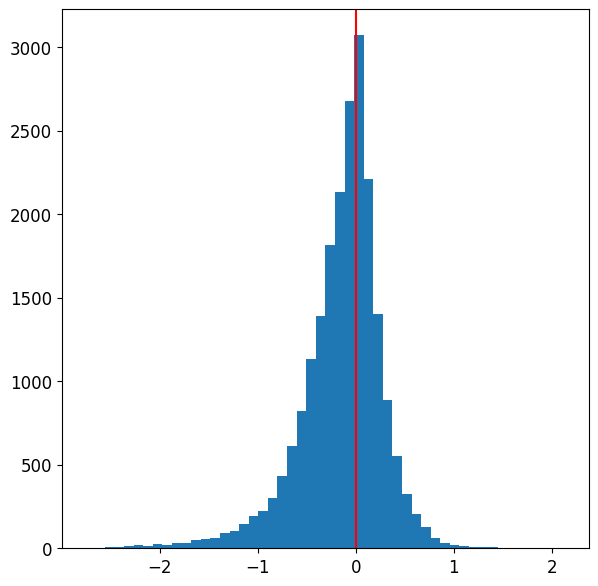

In [24]:
print(model_better.mean(), model_better.std(), model_better.max())
plt.hist(dif,bins=50)
plt.axvline(x=0, c='r')
plt.show()

Error: 4.0940, True Value: 2.7422, Predicted: -1.3518, Index: 176951.0000
Error: 3.8296, True Value: 2.9529, Predicted: -0.8767, Index: 176599.0000
Error: 3.6551, True Value: 2.7598, Predicted: -0.8953, Index: 183412.0000
Error: 3.2950, True Value: 2.2195, Predicted: -1.0755, Index: 178752.0000
Error: 3.2046, True Value: 1.9661, Predicted: -1.2385, Index: 176978.0000
Error: 3.1078, True Value: 2.3357, Predicted: -0.7721, Index: 177640.0000
Error: 3.0978, True Value: 2.5634, Predicted: -0.5343, Index: 176485.0000
Error: 2.9838, True Value: 3.1373, Predicted: 0.1535, Index: 193678.0000
Error: 2.9804, True Value: 2.4721, Predicted: -0.5083, Index: 113590.0000
Error: 2.9751, True Value: 2.2526, Predicted: -0.7226, Index: 162561.0000
Error: 2.9580, True Value: 2.3843, Predicted: -0.5737, Index: 203298.0000
Error: 2.9555, True Value: 2.5896, Predicted: -0.3660, Index: 176944.0000
Error: 2.9360, True Value: 2.2526, Predicted: -0.6834, Index: 112728.0000
Error: 2.9328, True Value: 2.5896, Pred

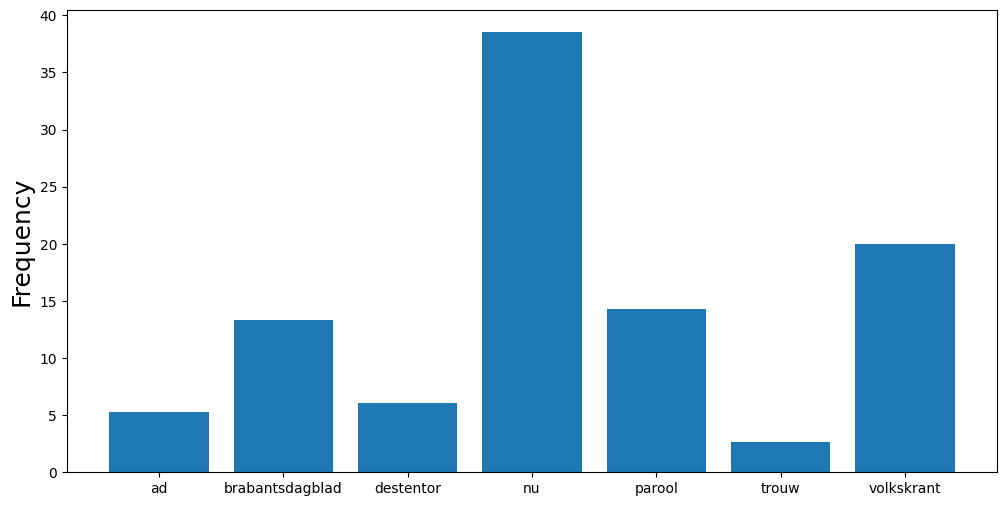

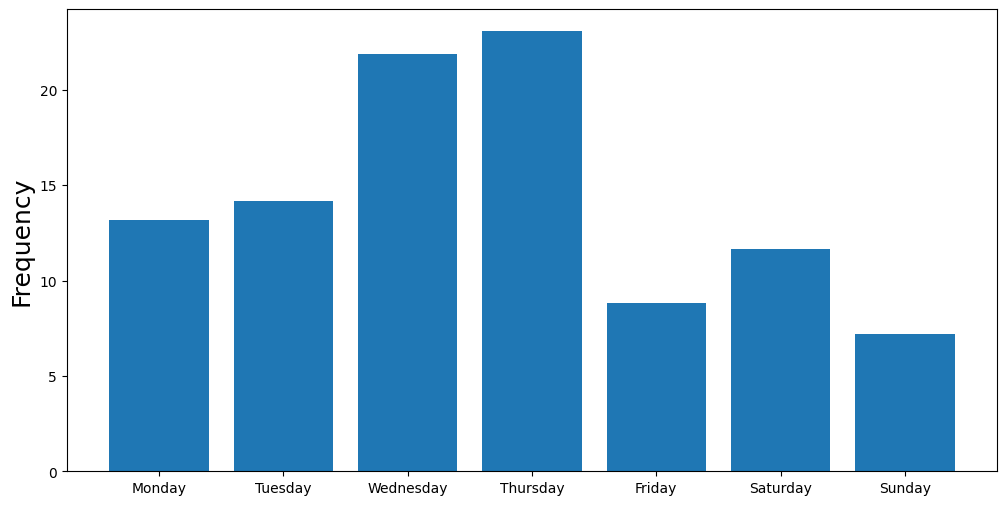

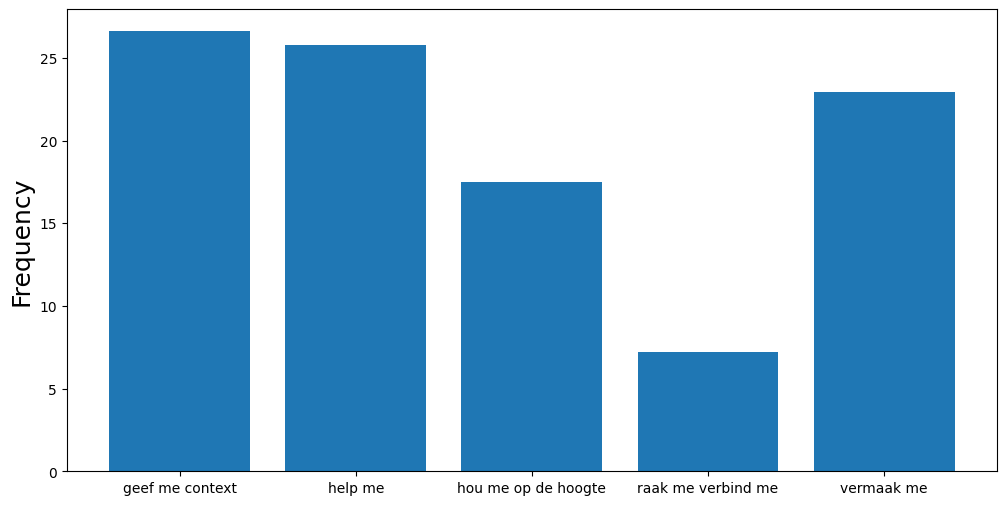

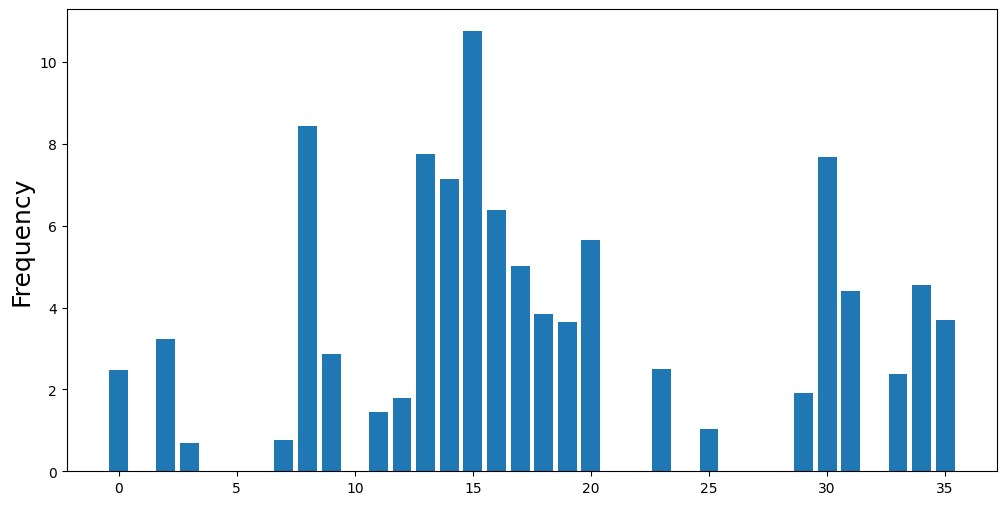

highest LDA frequency: misdaad with 10.7471143868767 percentage


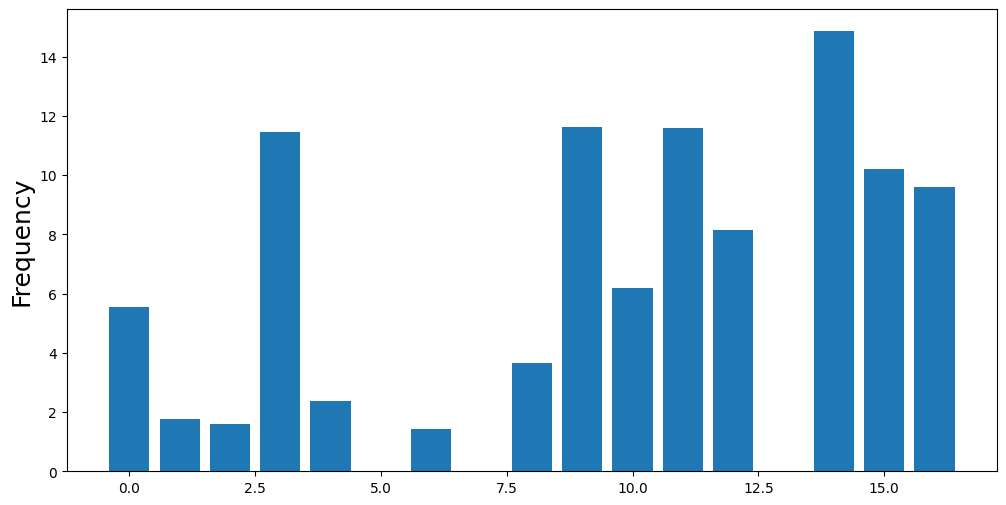

highest IPTC level 0 frequency: ramp, ongeval en noodsituatie incident with 14.858045495083541 percentage


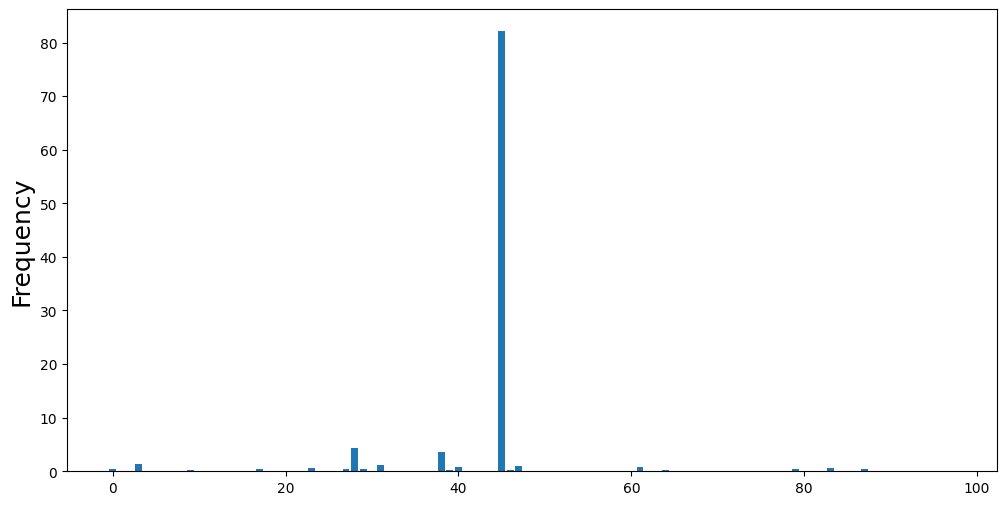

highest IPTC level 1 frequency: medisch beroep with 82.10043879392053 percentage


In [22]:
brands_in_csv_filename = [
    "ad",
    "brabantsdagblad",
    "destentor",
    "nu",
    "parool",
    "trouw",
    "volkskrant",
]
weekdays = [
	'Monday',
	'Tuesday',
	'Wednesday',
	'Thursday',
	'Friday',
	'Saturday',
	'Sunday'
]
user_needs=[
	'geef me context',
	'help me',
	'hou me op de hoogte',
	'raak me verbind me',
	'vermaak me'
]
LDA_topics = [
	'afval_en_milieuproblematiek', 
	'bestuur_en_organisatie',
	'bouwen_en_wonen',
	'brand',
	'consumeren_en_vrije_tijd',
	'duurzaamheid',
	'economie',
	'eten_en_drinken',
	'gemeentepolitiek',
	'gezondheid_en_zorg',
	'het_weer',
	'human_interest',
	'kunst_en_cultuur',
	'lokale_evenementen',
	'maatschappelijke_instellingen',
	'misdaad',
	'natuur',
	'nominatie_en_prijzen',
	'onderwijs',
	'optredens_en_voorstellingen',
	'overheidsbeleid',
	'politiek',
	'recht_en_justitie',
	'relatie_en_opvoeden',
	'religie',
	'samenleving',
	'sport',
	'technologie_en_handel',
	'vakbond_club_en_vereniging',
	'veiligheid',
	'verkeer',
	'verkeersongevallen',
	'voetbal',
	'wielrennen',
	'woon_en_leefomgeving',
	'zingeving_en_verhalen'
]

iptc_0_topics = [
	'economie, zaken en financiën',
	'sport',
	'misdaad, recht en gerechtigheid',
	'millieu',
	'het weer',
	'samenleving',
	'opleiding',
	'politiek',
	'arbeid',
	'conflict, oorlog en vrede',
	'religie en geloof',
	'levensstijl en vrije tijd',
	'menselijke interesse',
	'gezondheid',
	'ramp, ongeval en noodsituatie incident',
	'wetenschap en technologie',
	'kunst, cultuur, entertainment en media'
]

iptc_1_topics = ['wedstrijddiscipline', 'fundamentele rechten', 'mensheid', 'natuurwetenschap', 'cultuur', 'met pensioen', 'gezondheidsbehandeling', 'noodgeval', 'sociaal probleem', 'rechterlijke macht', 'technologie en techniek', 'wetenschappelijke instelling', 'demografie', 'markt en uitwisseling', 'sportorganisatie', 'overheidsgezondheidszorg', 'bedrijfsinformatie', 'natuur', 'religieus festival en vakantie', 'sociale wetenschappen', 'drugsgebruik in de sport', 'levensstijl', 'ziekten en aandoeningen', 'werk relaties', 'sport evenement', 'noodhulp', 'welzijn', 'godsdienstig onderwijs', 'familie', 'waarden', 'weersverschijnselen', 'ziektekostenverzekering', 'ongeval en noodgeval', 'bloemen en planten', 'economie', 'massa media', 'bloedbad', 'noodplanning', 'economische sector', 'toelatingsexamen', 'gemeenschappen', 'groep ouders', 'werkgelegenheid', 'werkloosheid', 'vakbonden', 'medisch beroep', 'weerswaarschuwing', 'wetenschappelijk onderzoek', 'maatschappelijke onrust', 'milieuvervuiling', 'gezondheidsfaciliteit', 'wiskunde', 'biomedische wetenschappen', 'religieuze leider', 'sociale conditie', 'politie', 'emigratie', 'ceremonie', 'internationale relaties', 'religieuze voorzieningen', 'kunst en vermaak', 'krijgsgevangenen', 'geloofssystemen', 'vredesproces', 'onderwijzen en leren', 'overheids beleid', 'discriminatie', 'sport industrie', 'gerechtigheid', 'sport transactie', 'gewapend conflict', 'weervoorspelling', 'disciplinaire maatregelen in de sport', 'ramp', 'terreurdaad', 'mensen', 'natuurlijke bronnen', 'klimaatverandering', 'gezondheidsorganisaties', 'wet', 'immigratie', 'school', 'politiek proces', 'dier', 'vrije tijd', 'misdrijf', 'leraren', 'verkiezing', 'leerplan', 'naoorlogse wederopbouw', 'educatieve testen en examens', 'arbeidswetgeving', 'studenten', 'religieuze tekst', 'sportlocatie', 'behoud', 'staatsgreep', 'regering']

errors = [(a.item(),b.numpy(),c.item(),d.item(), e) for (a,b,c,d,e) in zip(metric_score_test, dataset[test_dataset_indices][0].cpu(), y_test, y_pred_test, test_dataset_indices)]

errors.sort(reverse=True, key=lambda x: x[0])

brand_all_indices = [0 for _ in range(7)]
weekday_all_indices = [0 for _ in range(7)]
user_needs_all_indices = [0 for _ in range(5)]
LDA_all_indices = [0 for _ in range(36)]
iptc_0_all_indices = [0 for _ in range(17)]
iptc_1_all_indices = [0 for _ in range(98)]
for err in errors[:220000]:
	brand_all_index, _ = max(enumerate(err[1][0:7]), key=lambda x: x[1])
	brand_all_indices[brand_all_index] += 1
	weekday_all_index, _ = max(enumerate(err[1][8:15]), key=lambda x: x[1])
	weekday_all_indices[weekday_all_index] += 1
	user_needs_all_index, _ = max(enumerate(err[1][317:322]), key=lambda x: x[1])
	user_needs_all_indices[user_needs_all_index] += 1
	LDA_all_index, _ = max(enumerate(err[1][322:358]), key=lambda x: x[1])
	LDA_all_indices[LDA_all_index] += 1
	iptc_0_all_index, _ = max(enumerate(err[1][358:375]), key=lambda x: x[1])
	iptc_0_all_indices[iptc_0_all_index] += 1
	iptc_1_all_index, _ = max(enumerate(err[1][375:473]), key=lambda x: x[1])
	iptc_1_all_indices[iptc_1_all_index] += 1

brand_max_indices = [0 for _ in range(7)]
weekday_max_indices = [0 for _ in range(7)]
user_needs_max_indices = [0 for _ in range(5)]
LDA_max_indices = [0 for _ in range(36)]
iptc_0_max_indices = [0 for _ in range(17)]
iptc_1_max_indices = [0 for _ in range(98)]

for err in errors[:100]:
	print(f"Error: {err[0]:.4f}, True Value: {err[2]:.4f}, Predicted: {err[3]:.4f}, Index: {err[4]:.4f}")
	brand_max_index, _ = max(enumerate(err[1][0:7]), key=lambda x: x[1])
	brand_max_indices[brand_max_index] += 1
	weekday_max_index, _ = max(enumerate(err[1][8:15]), key=lambda x: x[1])
	weekday_max_indices[weekday_max_index] += 1
	user_needs_max_index, _ = max(enumerate(err[1][317:322]), key=lambda x: x[1])
	user_needs_max_indices[user_needs_max_index] += 1
	LDA_max_index, _ = max(enumerate(err[1][322:358]), key=lambda x: x[1])
	LDA_max_indices[LDA_max_index] += 1
	iptc_0_max_index, _ = max(enumerate(err[1][358:375]), key=lambda x: x[1])
	iptc_0_max_indices[iptc_0_max_index] += 1
	iptc_1_max_index, _ = max(enumerate(err[1][375:473]), key=lambda x: x[1])
	iptc_1_max_indices[iptc_1_max_index] += 1


brand_max_indices = [brand_max_indices[i] / brand_all_indices[i] for i in range(7)]
weekday_max_indices = [weekday_max_indices[i] / weekday_all_indices[i] for i in range(7)]
user_needs_max_indices = [user_needs_max_indices[i] / user_needs_all_indices[i] for i in range(5)]
LDA_max_indices = [LDA_max_indices[i] / LDA_all_indices[i] if LDA_all_indices[i] != 0 else 0 for i in range(36)]
iptc_0_max_indices = [iptc_0_max_indices[i] / iptc_0_all_indices[i] if iptc_0_all_indices[i] != 0 else 0 for i in range(17)]
iptc_1_max_indices = [iptc_1_max_indices[i] / iptc_1_all_indices[i] if iptc_1_all_indices[i] != 0 else 0 for i in range(98)]

brand_max_indices = [(brand_max_indices[i] / sum(brand_max_indices)) * 100 for i in range(7)]
weekday_max_indices = [(weekday_max_indices[i] / sum(weekday_max_indices)) * 100 for i in range(7)]
user_needs_max_indices = [(user_needs_max_indices[i] / sum(user_needs_max_indices)) * 100 for i in range(5)]
LDA_max_indices = [(LDA_max_indices[i] / sum(LDA_max_indices)) * 100 for i in range(36)]
iptc_0_max_indices = [(iptc_0_max_indices[i] / sum(iptc_0_max_indices)) * 100 for i in range(17)]
iptc_1_max_indices = [(iptc_1_max_indices[i] / sum(iptc_1_max_indices)) * 100 for i in range(98)]

plt.figure(figsize=(12, 6))
plt.ylabel('Frequency')
plt.bar(brands_in_csv_filename, brand_max_indices)
plt.show()

weekday_max_indices_s = weekday_max_indices[-2:] + weekday_max_indices[:-2]
plt.figure(figsize=(12, 6))
plt.ylabel('Frequency')
plt.bar(weekdays, weekday_max_indices_s)
plt.show()

plt.figure(figsize=(12, 6))
plt.ylabel('Frequency')
plt.bar(user_needs, user_needs_max_indices)
plt.show()

plt.figure(figsize=(12, 6))
plt.ylabel('Frequency')
plt.bar([i for i in range(36)], LDA_max_indices)
plt.show()

highest_LDA = max(LDA_max_indices)
index_highest_LDA = LDA_max_indices.index(highest_LDA)
print(f"highest LDA frequency: {LDA_topics[index_highest_LDA]} with {LDA_max_indices[index_highest_LDA]} percentage")

plt.figure(figsize=(12, 6))
plt.ylabel('Frequency')
plt.bar([i for i in range(17)], iptc_0_max_indices)
plt.show()

highest_iptc_0 = max(iptc_0_max_indices)
index_highest_iptc_0 = iptc_0_max_indices.index(highest_iptc_0)
print(f"highest IPTC level 0 frequency: {iptc_0_topics[index_highest_iptc_0]} with {iptc_0_max_indices[index_highest_iptc_0]} percentage")

plt.figure(figsize=(12, 6))
plt.ylabel('Frequency')
plt.bar([i for i in range(98)], iptc_1_max_indices)
plt.show()

highest_iptc_1 = max(iptc_1_max_indices)
index_highest_iptc_1 = iptc_1_max_indices.index(highest_iptc_1)
print(f"highest IPTC level 1 frequency: {iptc_1_topics[index_highest_iptc_1]} with {iptc_1_max_indices[index_highest_iptc_1]} percentage")